### Introduction 

__Ensemble__

A group of predictors is called an ensemble, the technique of grouping the predictors is called ensemble learning, and ensemble learning algorithm is called an ensemble method. 

Ex. random forest, a group of decision trees is an ensemble method.

Different algorithms can be ensembled in different ways, like stacking, boosting and bagging. 


### Voting Classifiers

We can combine different classifiers and select the most predicted class from the result (mode of predictors). Such combining is called voting classifier with hard voting, since the prediction class with most votes from the different classifier is the final classified class. Often, the voting classifier has higher accuracy than individual distinct classifiers. 


Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy

Creating the voting classifier in sklearn

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [14]:
log_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
svm_clf = SVC()

In [15]:
voting_clf = VotingClassifier(
            estimators = [('lr',log_clf),('rf',rf_clf),('svc',svm_clf)],
            voting = 'hard')

In [2]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 10000, noise = 0.15) 

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 42)

In [26]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [27]:
from joblib import dump

In [28]:
## Checking accuracy for all the classifiers
from sklearn.metrics import accuracy_score

classifiers = [log_clf, rf_clf, svm_clf, voting_clf]

for clf in classifiers: 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    dump(clf,''.join(['models/ch_07/',clf.__class__.__name__,'.pkl']))

LogisticRegression 0.878
RandomForestClassifier 0.989
SVC 0.9893333333333333
VotingClassifier 0.988


Voting Classifier performs similar to the better classifier. 

__Soft Voting__

If the classifiers have a ```predict_proba()``` class then sklearn can predict class with highest probability, this is called soft voting. It's often better than hard voting because it gives higher weight to high confidence votes. 

In [29]:
log_clf = LogisticRegression()
rf_clf = RandomForestClassifier()
svm_clf = SVC(probability = True)

voting_clf = VotingClassifier(
            estimators = [('lr',log_clf),('rf',rf_clf),('svc',svm_clf)],
            voting = 'soft')

In [30]:
## Checking accuracy for all the classifiers
from sklearn.metrics import accuracy_score

classifiers = [log_clf, rf_clf, svm_clf, voting_clf]

for clf in classifiers: 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    dump(clf,''.join(['models/ch_07/soft_voting_',clf.__class__.__name__,'.pkl']))

LogisticRegression 0.878
RandomForestClassifier 0.9873333333333333
SVC 0.9893333333333333
VotingClassifier 0.9876666666666667


### Bagging and Pasting

Another method of ensemble is where we train the same algorithm on different subset of the training set. When sampling is performed with replacement, this is called bagging (short for bootstrap aggregating). When sampling is performed without replacement, it's called pasting. both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.

Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors. The aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias
and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.

In [31]:
## Bagging and pasting in sklearn

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [34]:
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(),
        n_estimators = 500,
        max_samples = 100,
        bootstrap = True,
        n_jobs = 1)

In [36]:
bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))
dump(bag_clf,'models/ch_07/bag_clf.pkl')

BaggingClassifier 0.978


['models/ch_07/bag_clf.pkl']

The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Tree classifiers.

In [38]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train[:100],y_train[:100])
y_pred = dt_clf.predict(X_test)
print(dt_clf.__class__.__name__, accuracy_score(y_test, y_pred))
dump(dt_clf,'models/ch_07/dt_clf.pkl')

DecisionTreeClassifier 0.907


['models/ch_07/dt_clf.pkl']

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting; but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s variance is reduced. Overall, bagging often results in better models

#### Out-of-Bag Evaluation

In bagging, some samples may be sampples several times and some might not be sampled at all. By default, BaggingClassifier samples m trianing instances with replacement where m is the size of the trianing set. Hence some instances are kept oob evaluation, on which trianing is not done. We can evaluate the ensemble by averaging the oob evaluations of each predictor. 

In [39]:
## testing oob evaluation

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [40]:
bag_clf = BaggingClassifier(
        DecisionTreeClassifier(),
        n_estimators = 500,
        bootstrap = True,
        n_jobs = 1,
        oob_score = True)

In [41]:
bag_clf.fit(X_train,y_train)
print(bag_clf.oob_score_)
dump(bag_clf,'models/ch_07/bag_clf_oob.pkl')

0.9904285714285714


['models/ch_07/bag_clf_oob.pkl']

In [43]:
y_pred = bag_clf.predict(X_test)
print(dt_clf.__class__.__name__, accuracy_score(y_test, y_pred))

DecisionTreeClassifier 0.988


Accuracy on test and oob is pretty close

In [44]:
bag_clf.oob_decision_function_

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

### Random Patches and Random Subspaces

The ```BaggingClassifier``` supports sampling the features as well. Sampling is controlled by two hyperparamters
- max_feautres
- bootstrap_features

They both work same as max_samples and bootstrap but for feature samplinig instead of instance sampling. This is useful for high dimensional inputs. Sampling both training instances and features is called __random patches method.__ Sampling only features and keeping all instances is called __random subspaces method.__

### Random Forests


Random forest is an ensemble of decision trees, generally trained via the bagging method, typically with max_samples set to the size of the trainnig set. 

In [45]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)

##Paramters
#n_jobs: the number of jobs to run in parallel. -1 means  using all processors

In [46]:
rf_clf.fit(X_train,y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [47]:
y_pred = rf_clf.predict(X_test)

In [48]:
print(accuracy_score(y_pred,y_test))

0.9863333333333333


In [49]:
dump(rf_clf,'models/ch_07/rf_clf.pkl')

['models/ch_07/rf_clf.pkl']

Random forest algorithm introduces extra randomness when growing trees, instead of searching for the very best feature when splitting node, it searchesfor the best feature among a random subset of features. 

The algorithm results in greater tree diversity, which trades a higher bias for a lower vairance, generally yielding a better model. 

In [50]:
## Bagging classifier is roughly eq to random forest

bag_clf = BaggingClassifier(
DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

In [51]:
bag_clf.fit(X_train,y_train)
dump(bag_clf,'models/ch_07/bag_clf_rf.pkl')

['models/ch_07/bag_clf_rf.pkl']

In [52]:
y_pred = bag_clf.predict(X_test)
print(dt_clf.__class__.__name__, accuracy_score(y_test, y_pred))

DecisionTreeClassifier 0.9846666666666667


#### Extra-Trees

It is possible to introduce more randomness by making random thresholds for each feature rather than searhcing for the best possible threshold. 

A forest of such random trees is called __extremely randomized trees__ ensemple (or __extra trees__) This technique trades more bias for a lower vairance. It's also much faster to train extra trees than random forest, since finding the best threshold for each feature at every node is elimianted. 

```sklearn``` has a ```ExtraTreesClassifier``` for creating such trees. In general, there is no algo better out of Extra tree or random forest, it's better to check with cross validation.

#### Feature Importance

sklearn computes the feature imp for random forest features automatically, such that all feature imp sum up to 1. 

In [53]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris["data"]
y = iris["target"]

In [54]:
rf_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rf_clf.fit(X,y)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

<BarContainer object of 4 artists>

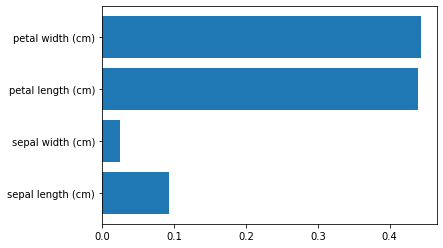

In [59]:
import matplotlib.pyplot as plt
plt.barh(iris.feature_names, rf_clf.feature_importances_)

In [61]:
for name, score in zip(iris["feature_names"], rf_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09259941403225018
sepal width (cm) 0.02459758498789982
petal length (cm) 0.4396038126017132
petal width (cm) 0.4431991883781368


### Boosting

Booting (orginally called __hypothesis boosting__) refers to combining the weak learner into a stronger learner. General idea of boosting is to train the learners sequentially, such that each one corrects the behavior of the previous one. There are many boosting methods available:

- AdaBoosting (adaptive boosting)
- Gradient Boosting
- Extreme gradient boosting

#### AdaBoost

Adaboost pays more attention to the training instance that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. So if we were trianing a decision tree, ado boost would take a smaple, train it get the weights, then on next turn increase the weight of the misclassified training instances. Then train another classifier and  and update the weight and so on, gradually making it better. 

Once all the predictors are trianed, the ensemble makes predictions very much like the bagging or pasting, except the predictors have different weights depending on overall accuracy on weighted trianing set. 

One limitation to the sequantial learning is it cannot be parallelized. Hence, it doesn't scale as well as bagging or pasting. 

__Maths behind the Adaboost algorithm:__

- initially each instance has a weight ($w^i$) 1/m with m as the number of instance. 
- wgtd error rate ($r_i$) is defined for the predictor as the sum of weight of wrong classification by sum of weights of all instances
- the predictor weight is then calculatede with a learning rate hyperparamter (defualt = 1). 
    - The more accurate the predictor higher the weight is 
    - on random gues, the weight is closer to 0
    - more wrong then right, then the weight is negative
    
    $ \alpha_j = \eta log (\frac {1-r_j} {r_j}) $ 
    
- Next, adaboost updates the weight for instances
    - if the prediction is correct, then weight is same
    - if the prediction is wrong, the new weight is old wgt times $exp(\alpha_j)$
- then all instances are normalized (divided the by sum of all weights)
- next a new predictor is trained using the new wgts and the proccess is repeated again
- The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth = 1), 
                                   n_estimators = 200,
                                   algorithm = "SAMME.R",
                                  learning_rate = 0.5)

In [6]:
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [8]:
from sklearn.metrics import accuracy_score

y_pred = ada_clf.predict(X_test)
print(ada_clf.__class__.__name__, accuracy_score(y_test, y_pred))

AdaBoostClassifier 0.9906666666666667


In [9]:
from joblib import dump

dump(ada_clf,'models/ch_07/ada_clf.pkl')

['models/ch_07/ada_clf.pkl']

#### Gradient Boosting

Like AdaBoost, Gradient boosting also works by sequentially adding predictors to an ensemble, each one correcting its predecessor. The difference in GB and AB is in the method of deciding the paramters for new predictor. B updates the weight at each instance for new predictor, GB fits the new predictor on the residual errors made by the previous predictor. 


In [17]:
import numpy as np

##Creating training set
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

##Creating validation set
m = 10
X_new = 6 * np.random.rand(m, 1) - 3
y_new = 0.5 * X_new**2 + X_new + 2 + np.random.randn(m, 1)

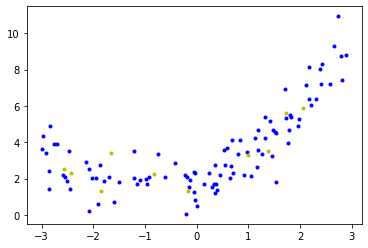

In [20]:
import matplotlib.pyplot as plt

plt.plot(X,y,"b."  )
plt.plot(X_new,y_new,"y.")
plt.show()

In [21]:
from sklearn.tree import DecisionTreeRegressor

tree_reg_1 = DecisionTreeRegressor(max_depth = 2)
tree_reg_1.fit(X,y)
dump(tree_reg_1,'models/ch_07/gb_tree_reg_1.pkl')

['models/ch_07/gb_tree_reg_1.pkl']

In [22]:
##Predicting and training a sequential regressor on the above model

y2 = y - tree_reg_1.predict(X)


tree_reg_2 = DecisionTreeRegressor(max_depth = 2)
tree_reg_2.fit(X,y)
dump(tree_reg_2,'models/ch_07/gb_tree_reg_2.pkl')

['models/ch_07/gb_tree_reg_2.pkl']

In [23]:
##Predicting and training a sequential regressor on the above model

y3 = y2- tree_reg_2.predict(X)


tree_reg_3 = DecisionTreeRegressor(max_depth = 2)
tree_reg_3.fit(X,y)
dump(tree_reg_3,'models/ch_07/gb_tree_reg_3.pkl')

['models/ch_07/gb_tree_reg_3.pkl']

In [40]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg_1, tree_reg_2, tree_reg_3))/3

In [41]:
from sklearn.metrics import r2_score, mean_squared_error

print('R2 Score: ', r2_score(y_pred,y_new))
print('MSE: ', mean_squared_error(y_pred,y_new))
print('RMSE: ',np.sqrt(mean_squared_error(y_pred,y_new)))

R2 Score:  0.8471231958223349
MSE:  0.3222871101512776
RMSE:  0.5677033645763231


In [42]:
##Checking the accuracy of the 3 trees in steps

print("Tree 1")
y_pred = sum(tree.predict(X_new) for tree in [tree_reg_1])/1

print('R2 Score: ', r2_score(y_pred,y_new))
print('MSE: ', mean_squared_error(y_pred,y_new))
print('RMSE: ',np.sqrt(mean_squared_error(y_pred,y_new)))
print("----------------------------")


print("Tree 2")
y_pred = sum(tree.predict(X_new) for tree in [tree_reg_1, tree_reg_2])/2

print('R2 Score: ', r2_score(y_pred,y_new))
print('MSE: ', mean_squared_error(y_pred,y_new))
print('RMSE: ',np.sqrt(mean_squared_error(y_pred,y_new)))
print("----------------------------")


print("Tree 3")
y_pred = sum(tree.predict(X_new) for tree in [tree_reg_1, tree_reg_2,tree_reg_3])/3

print('R2 Score: ', r2_score(y_pred,y_new))
print('MSE: ', mean_squared_error(y_pred,y_new))
print('RMSE: ',np.sqrt(mean_squared_error(y_pred,y_new)))
print("----------------------------")

Tree 1
R2 Score:  0.8471231958223349
MSE:  0.3222871101512776
RMSE:  0.5677033645763231
----------------------------
Tree 2
R2 Score:  0.8471231958223349
MSE:  0.3222871101512776
RMSE:  0.5677033645763231
----------------------------
Tree 3
R2 Score:  0.8471231958223349
MSE:  0.3222871101512776
RMSE:  0.5677033645763231
----------------------------


In [36]:
##Usign GBRT from sklearn

from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3, learning_rate = 1.0)
gbrt.fit(X,y)
dump(gbrt,'models/ch_07/gbrt.pkl')

C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['models/ch_07/gbrt.pkl']

In [39]:
y_pred = gbrt.predict(X_new)

print('R2 Score: ', r2_score(y_pred,y_new))
print('MSE: ', mean_squared_error(y_pred,y_new))
print('RMSE: ',np.sqrt(mean_squared_error(y_pred,y_new)))
print("----------------------------")

R2 Score:  0.8440103351391876
MSE:  0.37317804393536474
RMSE:  0.6108830034755958
----------------------------


The learning rate hyperparamter scales the contributions of each tree. If we set it to low value, like 0.1 we need more trees in the ensemble to fit hte trinaing set, but the predictions with generalize better. This is called __shrinkage__ 

To find optimal number of trees, we can use early stopping. A simple way to implement is to use the ```staged_predict()``` method which returns an iterator oer the predictions made by the ensemble at each stage of training ( with one, two trees) 

In [37]:
## Training 120 trees with GBRT

import numpy as no
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import numpy as np

##Creating training set
m = 10000
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state =42)

In [38]:
gbrt_120 = GradientBoostingRegressor(max_depth = 2, n_estimators = 120)
gbrt_120.fit(X_train,y_train)
dump(gbrt_120, 'models/ch_07/gbrt_120.pkl')

C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['models/ch_07/gbrt_120.pkl']

In [43]:
y_pred = gbrt.predict(X_test)

print('R2 Score: ', r2_score(y_pred,y_test))
print('MSE: ', mean_squared_error(y_pred,y_test))
print('RMSE: ',np.sqrt(mean_squared_error(y_pred,y_test)))
print("----------------------------")

R2 Score:  0.7290609838498993
MSE:  1.275234656957206
RMSE:  1.1292628821302886
----------------------------


In [46]:
##Implementing early stopping using warm_start = True

gbrt_es = GradientBoostingRegressor(max_depth = 2, warm_start = True)

min_val_error = float("inf")
error_going_up = 0

for n_estimators in range(1,120):
    gbrt_es.n_estimators = n_estimators
    gbrt_es.fit(X_train,y_train)
    y_pred = gbrt_es.predict(X_test)
    val_error = mean_squared_error(y_pred,y_test)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break ##Early Stopping

C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when 

C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when 

C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\apurv\anaconda3\envs\hands-on-ml-book\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when 

In [47]:
val_error
##Better then the full 120 model runs 

0.9710140246424315

In [48]:
dump(gbrt_es,'models/ch_07/gbrt_es.pkl')

['models/ch_07/gbrt_es.pkl']

__Stochastic Gradient Boosting__

```GradientBoostingRegressor``` class also support a subsample hyperparamter, which specifies the fraction of training instances to be used for training each tree. This technique trades a high bias for a lower variance and speeds up the training considerably. 

It is possible to use gradient boosting with other cost functions. This is controlled by loss hyperparamter. 

In [50]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
dump(xgb_reg,'models/ch_07/xgb_reg.pkl')

['models/ch_07/xgb_reg.pkl']

In [52]:
y_pred = xgb_reg.predict(X_test)

In [53]:
print('R2 Score: ', r2_score(y_pred,y_test))
print('MSE: ', mean_squared_error(y_pred,y_test))
print('RMSE: ',np.sqrt(mean_squared_error(y_pred,y_test)))
print("----------------------------")

R2 Score:  0.7939054500451354
MSE:  1.0424502417151227
RMSE:  1.0210045258054063
----------------------------


In [54]:
##XGBoost has a inbuilt early stopping hyperparamter

xgb_reg.fit(X_train, y_train, eval_set = [(X_test,y_test)], early_stopping_rounds = 2)
dump(xgb_reg,'models/ch_07/xgb_reg_es.pkl')

[0]	validation_0-rmse:2.77058
[1]	validation_0-rmse:2.05706
[2]	validation_0-rmse:1.59780
[3]	validation_0-rmse:1.31614
[4]	validation_0-rmse:1.15583
[5]	validation_0-rmse:1.07032
[6]	validation_0-rmse:1.02825
[7]	validation_0-rmse:1.00709
[8]	validation_0-rmse:0.99908
[9]	validation_0-rmse:0.99435
[10]	validation_0-rmse:0.99329
[11]	validation_0-rmse:0.99284
[12]	validation_0-rmse:0.99316
[13]	validation_0-rmse:0.99278
[14]	validation_0-rmse:0.99336
[15]	validation_0-rmse:0.99371


['models/ch_07/xgb_reg_es.pkl']

In [56]:
y_pred = xgb_reg.predict(X_test)

print('R2 Score: ', r2_score(y_pred,y_test))
print('MSE: ', mean_squared_error(y_pred,y_test))
print('RMSE: ',np.sqrt(mean_squared_error(y_pred,y_test)))
print("----------------------------")

R2 Score:  0.7985261282796258
MSE:  0.9856108075624117
RMSE:  0.9927793347780823
----------------------------


Early stopping in XGB gives better result than full model run


### Stacking

stacking is short for stacked generalization. It's based on a simple idea, instead of using trivial functions like hard voting to aggregate predictions of all predictors in an ensemble we should train a model to perform this aggregation. There are several distinct predictors and then a belnder, which aggregates the predictors. The blender is trained on a __hold-out set__ after dividing the training set into two. This ensures the predictors are clean, since they never saw this data during training. 

The new training set can also be created by combining the predicted values from all the predictors. It's actually possible to train several different blenders this way, to get a whole layer of blenders. The trick is to split the dataset into 3 parts. ffirst is used to train the predictors, second is used to create the new training set, third is used to create training set for the third layer. Once this is done, we can make the predictions for a new instance by going through each layer sequentially. 

```sklearn doesn't support stacking directly, we can do manual implementation (in exercises) or use an open source implementation like brew``` 

### Exercises


__1. If you have trained five different models on the exact same training data, and they all achieve 95% precision, is there any chance that you can combine these models to get better results? If so, how? If not, why?__

If all the models are high performing we can combine them using hard voting, with take the mode of the prediction results to get the final prediction. Hard voting generally outperforms the best performing model and can slightly increase the performance metrics.  


__2. What is the difference between hard and soft voting classifiers?__

hard voting works well when the models are different and genreate the class prediction as the final predictions, har voting then selects the mode of the predictions and classifies that as the final prediction. Soft voting works well when the classification algos can generate the probabilty scores for each class, hence instead of taking the mode of the prediction classes it takes into account the higher confidence and performs slighly better than hard voting classifiers.


__3. Is it possible to speed up training of a bagging ensemble by distributing it across multiple servers? What about pasting ensembles, boosting ensembles, Random Forests, or stacking ensembles?__

Yes, bagging uses the result of individually trained trees and then combines the result of these to get hte final prediction, hence they can be parallelized or distributed into different servers for faster computation.

Random forest is based on bagging which training individual decision trees parallely and averages the result for final prediction, same with pasting. These both can run parallely and hence are faster to train. Boosting and Stacking ensembles train sequentially, hence they are dependent on the output of the previous predictor which cannot be parallized resulting in more trianing time.  


__4. What is the benefit of out-of-bag evaluation?__

out-of-bad evaluation is done on the new data that the predictor is not trained on, hence during training itself, the predictor can judge the perofrmance and correct itself without waitning for the full model training and then evaluation on the validation dataset.


__5. What makes Extra-Trees more random than regular Random Forests? How can
this extra randomness help? Are Extra-Trees slower or faster than regular
Random Forests?__

Extra trees select the features on random for each subset and hence doesn't wait for the selection of the best features for the particular dataset, and a optimal threshold for each tree resulting in faster trianing. This adds an extra randomness to the forest trees and acts like a form of regularization.  


__6. If your AdaBoost ensemble underfits the training data, which hyperparameters should you tweak and how?__

We can increase the estimators for the adaboost in case of underfitting or reduce the regularization which may be constraining the predictor. We can increase the learning rate as well, which can increase the predictor weight for more accurate predictor, amplifying the correct predictions.  


__7. If your Gradient Boosting ensemble overfits the training set, should you increase or decrease the learning rate?__

we should decrease the learning rate if the GB is overfitting the dataset, we can aslo try early stopping.


__8. Step wise__

__a. Load the MNIST data (introduced in Chapter 3), and__

__b. split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing).__

__c. Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM classifier.__

__d. Next, try to combine them into an ensemble that outperforms each individual classifier on the validation set, using soft or hard voting.__

__e. Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?__

In [1]:
##Loading the dataset

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"],mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = X[:50000], X[50000:60000], X[60000:],y[:50000], y[50000:60000], y[60000:]

In [4]:
## Training RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train,y_train)

RandomForestClassifier()

In [5]:
## Training ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier()
et_clf.fit(X_train,y_train)

ExtraTreesClassifier()

In [6]:
##Trianing SVC
from sklearn.svm import SVC

svc_clf = SVC()
svc_clf.fit(X_train,y_train)

SVC()

In [7]:
##Saving the individual models
from joblib import dump

dump(rf_clf,'models/ch_07/ex_rf_clf.pkl')
dump(et_clf,'models/ch_07/ex_et_clf.pkl')
dump(svc_clf,'models/ch_07/ex_svc_clf.pkl')

['models/ch_07/ex_svc_clf.pkl']

In [8]:
##Evaluaing individual models on val set
from sklearn.metrics import accuracy_score

clfs = [rf_clf,et_clf,svc_clf]

for clf in clfs:
    y_pred = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_pred,y_val))    

RandomForestClassifier 0.9724
ExtraTreesClassifier 0.9743
SVC 0.9802


#### Hard Voting

In [9]:
from sklearn.ensemble import VotingClassifier

voting_clf_hv = VotingClassifier(
            estimators = [('rf',rf_clf),('et',et_clf),('svc',svc_clf)],
            voting = 'hard')

voting_clf_hv.fit(X_train,y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('et', ExtraTreesClassifier()), ('svc', SVC())])

In [10]:
y_pred = voting_clf_hv.predict(X_val)
print(voting_clf_hv.__class__.__name__, accuracy_score(y_pred,y_val))
dump(voting_clf_hv,'models/ch_07/ex_voting_clf_hv.pkl')

VotingClassifier 0.977


['models/ch_07/ex_voting_clf_hv.pkl']

__Soft Voting__

In [11]:
voting_clf_sv = VotingClassifier(
            estimators = [('rf',rf_clf),('et',et_clf),('svc',SVC(probability = True))],
            voting = 'soft')

voting_clf_sv.fit(X_train,y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('et', ExtraTreesClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [12]:
y_pred = voting_clf_sv.predict(X_val)
print(voting_clf_sv.__class__.__name__, accuracy_score(y_pred,y_val))
dump(voting_clf_sv,'models/ch_07/ex_voting_clf_sv.pkl')

VotingClassifier 0.9809


['models/ch_07/ex_voting_clf_sv.pkl']

In [13]:
## Evaluation on test data

from sklearn.metrics import accuracy_score

clfs = [rf_clf,et_clf,svc_clf,voting_clf_hv,voting_clf_sv]

for clf in clfs:
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_pred,y_test)) 

RandomForestClassifier 0.9691
ExtraTreesClassifier 0.9714
SVC 0.9785
VotingClassifier 0.9735
VotingClassifier 0.9784


__9. Step wise__

__a. Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image’s class.__

__b. Train a classifier on this new training set.__

__Congratulations, you have just trained a blender, and together with the classifiers it forms a stacking ensemble!__

__c. Now evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble’s predictions.__

__d. How does it compare to the voting classifier you trained earlier?__

In [4]:
from joblib import load

rf_clf = load('models/ch_07/ex_rf_clf.pkl')
et_clf = load('models/ch_07/ex_et_clf.pkl')
svc_clf = load('models/ch_07/ex_svc_clf.pkl')
voting_clf_sv = load('models/ch_07/ex_voting_clf_sv.pkl')
voting_clf_hv = load('models/ch_07/ex_voting_clf_hv.pkl')

In [30]:
X_train_new = []

for i in range(0,len(X_val)):
    t = X_val[i:i+1]
    y_pred_rf = rf_clf.predict(t)
    y_pred_et = et_clf.predict(t)
    y_pred_svc = svc_clf.predict(t)
    X_train_new.append([y_pred_rf[0],y_pred_et[0],y_pred_svc[0]])

In [32]:
X_train_new[0]

['3', '3', '3']

In [34]:
##SVC as blender
from sklearn.svm import SVC

svc_blender  = SVC()
svc_blender.fit(X_train_new, y_val)

SVC()

In [43]:
##RF as blender

from sklearn.ensemble import RandomForestClassifier
rf_blender = RandomForestClassifier(n_estimators=10)
rf_blender.fit(X_train_new, y_val)

RandomForestClassifier(n_estimators=10)

In [36]:
from joblib import dump

dump(svc_blender,'models/ch_07/ex_svc_blender.pkl')

['models/ch_07/ex_svc_blender.pkl']

In [44]:
dump(rf_blender,'models/ch_07/ex_rf_blender.pkl')

['models/ch_07/ex_rf_blender.pkl']

In [39]:
X_test_new = []

for i in range(0,len(X_test)):
    t = X_test[i:i+1]
    y_pred_rf = rf_clf.predict(t)
    y_pred_et = et_clf.predict(t)
    y_pred_svc = svc_clf.predict(t)
    X_test_new.append([y_pred_rf[0],y_pred_et[0],y_pred_svc[0]])

In [41]:
from sklearn.metrics import accuracy_score

y_pred = svc_blender.predict(X_test_new)
accuracy_score(y_pred,y_test)

0.9697

In [45]:
y_pred = rf_blender.predict(X_test_new)
accuracy_score(y_pred,y_test)

0.9751

The Accuracy on the Final Test set are:

- RandomForestClassifier 0.9691
- ExtraTreesClassifier 0.9714
- SVC 0.9785
- Hard VotingClassifier 0.9735
- Soft VotingClassifier 0.9784
- SCV blender Stacked Classifier 0.9697
- RandomForest blender Stacked Classifier 0.9751


In individual classifiers, SVC performed best with accuracy of 97.85%
Using Voting, Hard voting peroforms better then Random forest and Extra tree classifier, Soft voting performs similar to SVC.
Using Stacking with SVC blender the accuracy is slightly lower at 96.97%, stacking with random forest classifier is higher than hard voting but lower than soft voting at 97.51% 